In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, next_states, rewards, dones, rates

In [4]:
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Input layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Hidden layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        actions_logits = tf.layers.dense(inputs=nl2, units=action_size)
        return actions_logits

In [5]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Hidden layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        Qs_logits = tf.layers.dense(inputs=nl2, units=1)
        return Qs_logits

In [6]:
def model_loss(state_size, action_size, hidden_size, states, actions, next_states, rewards, dones, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    gloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    dQs = discriminator(states=states, actions=actions_labels, action_size=action_size, hidden_size=hidden_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs,
                                                                   labels=rates)) # [0, 1]
    next_actions_logits = generator(states=next_states, hidden_size=hidden_size, action_size=action_size, 
                                    reuse=True)
    nextQs_logits = discriminator(states=next_states, actions=next_actions_logits, action_size=action_size, 
                                  hidden_size=hidden_size, reuse=True)
    nextQs = tf.reshape(nextQs_logits, shape=[-1])
    targetQs = rewards + (0.99 * nextQs * (1-dones))
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    glossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs,
                                                                    labels=tf.nn.sigmoid(targetQs))) # [0, 1]
    return actions_logits, gloss, dloss, glossQ

In [7]:
def model_opt(g_loss, d_loss, g_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        g_optQ = tf.train.AdamOptimizer(g_learning_rate).minimize(g_lossQ, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt, g_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.g_loss, self.d_loss, self.g_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, state_size=state_size, # model init parameters
            states=self.states, actions=self.actions, next_states=self.next_states, rewards=self.rewards, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt, self.g_optQ = model_opt(g_loss=self.g_loss, 
                                                        d_loss=self.d_loss,
                                                        g_lossQ=self.g_lossQ,
                                                        g_learning_rate=g_learning_rate, 
                                                        d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            gloss, _, dloss, _ = sess.run([model.g_loss, model.g_opt, model.d_loss, model.d_opt], 
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones, 
                                                       model.rates: rates})
            glossQ, _ = sess.run([model.g_lossQ, model.g_optQ], feed_dict = {model.states: states, 
                                                                             model.actions: actions,
                                                                             model.next_states: next_states,
                                                                             model.rewards: rewards,
                                                                             model.dones: dones, 
                                                                             model.rates: rates})
            dloss_batch.append(dloss)
            gloss_batch.append(gloss)
            glossQ_batch.append(glossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:16.0000 R:16.0000 rate:0.0320 gloss:0.6997 dloss:0.8295 glossQ:0.6617 exploreP:0.9984
Episode:1 meanR:20.5000 R:25.0000 rate:0.0500 gloss:0.6959 dloss:0.8147 glossQ:0.6668 exploreP:0.9959
Episode:2 meanR:33.6667 R:60.0000 rate:0.1200 gloss:0.6944 dloss:0.7993 glossQ:0.6748 exploreP:0.9901
Episode:3 meanR:31.0000 R:23.0000 rate:0.0460 gloss:0.6928 dloss:0.7778 glossQ:0.6838 exploreP:0.9878
Episode:4 meanR:28.0000 R:16.0000 rate:0.0320 gloss:0.6943 dloss:0.7686 glossQ:0.6894 exploreP:0.9862
Episode:5 meanR:25.8333 R:15.0000 rate:0.0300 gloss:0.6932 dloss:0.7691 glossQ:0.6902 exploreP:0.9848
Episode:6 meanR:24.4286 R:16.0000 rate:0.0320 gloss:0.6919 dloss:0.7627 glossQ:0.6937 exploreP:0.9832
Episode:7 meanR:23.8750 R:20.0000 rate:0.0400 gloss:0.6909 dloss:0.7559 glossQ:0.6972 exploreP:0.9813
Episode:8 meanR:23.8889 R:24.0000 rate:0.0480 gloss:0.6910 dloss:0.7449 glossQ:0.7021 exploreP:0.9789
Episode:9 meanR:22.9000 R:14.0000 rate:0.0280 gloss:0.6888 dloss:0.7423 glossQ:0.7

Episode:80 meanR:23.1975 R:18.0000 rate:0.0360 gloss:0.7622 dloss:0.4005 glossQ:0.6430 exploreP:0.8304
Episode:81 meanR:23.2317 R:26.0000 rate:0.0520 gloss:0.7512 dloss:0.3996 glossQ:0.6514 exploreP:0.8283
Episode:82 meanR:23.1205 R:14.0000 rate:0.0280 gloss:0.7932 dloss:0.4075 glossQ:0.6745 exploreP:0.8271
Episode:83 meanR:23.0000 R:13.0000 rate:0.0260 gloss:0.7405 dloss:0.4192 glossQ:0.6673 exploreP:0.8261
Episode:84 meanR:22.9647 R:20.0000 rate:0.0400 gloss:0.7510 dloss:0.3905 glossQ:0.6359 exploreP:0.8244
Episode:85 meanR:22.8140 R:10.0000 rate:0.0200 gloss:0.7630 dloss:0.4048 glossQ:0.6466 exploreP:0.8236
Episode:86 meanR:22.6897 R:12.0000 rate:0.0240 gloss:0.7281 dloss:0.4050 glossQ:0.6558 exploreP:0.8227
Episode:87 meanR:22.7614 R:29.0000 rate:0.0580 gloss:0.7525 dloss:0.3850 glossQ:0.6470 exploreP:0.8203
Episode:88 meanR:22.6742 R:15.0000 rate:0.0300 gloss:0.7446 dloss:0.4139 glossQ:0.6320 exploreP:0.8191
Episode:89 meanR:22.6444 R:20.0000 rate:0.0400 gloss:0.7632 dloss:0.3905 

Episode:160 meanR:19.7600 R:14.0000 rate:0.0280 gloss:0.7051 dloss:0.3678 glossQ:0.6566 exploreP:0.7146
Episode:161 meanR:19.9200 R:35.0000 rate:0.0700 gloss:0.7260 dloss:0.3789 glossQ:0.6468 exploreP:0.7121
Episode:162 meanR:19.7600 R:49.0000 rate:0.0980 gloss:0.7211 dloss:0.3738 glossQ:0.6481 exploreP:0.7087
Episode:163 meanR:19.3300 R:21.0000 rate:0.0420 gloss:0.7079 dloss:0.3897 glossQ:0.6524 exploreP:0.7072
Episode:164 meanR:19.4700 R:28.0000 rate:0.0560 gloss:0.7064 dloss:0.3861 glossQ:0.6532 exploreP:0.7053
Episode:165 meanR:19.4500 R:14.0000 rate:0.0280 gloss:0.7186 dloss:0.3673 glossQ:0.6519 exploreP:0.7043
Episode:166 meanR:19.7500 R:43.0000 rate:0.0860 gloss:0.7151 dloss:0.3837 glossQ:0.6570 exploreP:0.7013
Episode:167 meanR:19.8400 R:24.0000 rate:0.0480 gloss:0.7156 dloss:0.3821 glossQ:0.6554 exploreP:0.6997
Episode:168 meanR:19.8300 R:19.0000 rate:0.0380 gloss:0.7124 dloss:0.3618 glossQ:0.6576 exploreP:0.6984
Episode:169 meanR:19.9800 R:41.0000 rate:0.0820 gloss:0.7254 dlo

Episode:239 meanR:44.1400 R:106.0000 rate:0.2120 gloss:0.7003 dloss:0.3872 glossQ:0.6896 exploreP:0.4808
Episode:240 meanR:44.5400 R:52.0000 rate:0.1040 gloss:0.7047 dloss:0.3911 glossQ:0.6899 exploreP:0.4784
Episode:241 meanR:44.8300 R:49.0000 rate:0.0980 gloss:0.6954 dloss:0.3850 glossQ:0.6878 exploreP:0.4761
Episode:242 meanR:45.7500 R:105.0000 rate:0.2100 gloss:0.7016 dloss:0.3865 glossQ:0.6872 exploreP:0.4712
Episode:243 meanR:46.5800 R:97.0000 rate:0.1940 gloss:0.7171 dloss:0.3908 glossQ:0.6906 exploreP:0.4668
Episode:244 meanR:47.0300 R:54.0000 rate:0.1080 gloss:0.6980 dloss:0.3867 glossQ:0.6880 exploreP:0.4643
Episode:245 meanR:47.8400 R:103.0000 rate:0.2060 gloss:0.7104 dloss:0.4022 glossQ:0.6873 exploreP:0.4597
Episode:246 meanR:47.9300 R:28.0000 rate:0.0560 gloss:0.6985 dloss:0.3837 glossQ:0.6919 exploreP:0.4584
Episode:247 meanR:48.4200 R:71.0000 rate:0.1420 gloss:0.7014 dloss:0.3948 glossQ:0.6926 exploreP:0.4552
Episode:248 meanR:48.5300 R:29.0000 rate:0.0580 gloss:0.7028 

Episode:318 meanR:52.0800 R:14.0000 rate:0.0280 gloss:0.7034 dloss:0.3836 glossQ:0.6795 exploreP:0.3388
Episode:319 meanR:51.1500 R:13.0000 rate:0.0260 gloss:0.6956 dloss:0.3801 glossQ:0.6753 exploreP:0.3384
Episode:320 meanR:50.7100 R:18.0000 rate:0.0360 gloss:0.7106 dloss:0.4069 glossQ:0.6764 exploreP:0.3378
Episode:321 meanR:50.4300 R:13.0000 rate:0.0260 gloss:0.7049 dloss:0.4016 glossQ:0.6779 exploreP:0.3374
Episode:322 meanR:50.2700 R:11.0000 rate:0.0220 gloss:0.7021 dloss:0.3805 glossQ:0.6804 exploreP:0.3370
Episode:323 meanR:48.3600 R:11.0000 rate:0.0220 gloss:0.7061 dloss:0.4340 glossQ:0.6781 exploreP:0.3367
Episode:324 meanR:47.2400 R:11.0000 rate:0.0220 gloss:0.7039 dloss:0.3907 glossQ:0.6695 exploreP:0.3363
Episode:325 meanR:46.7800 R:15.0000 rate:0.0300 gloss:0.7009 dloss:0.3795 glossQ:0.6642 exploreP:0.3358
Episode:326 meanR:45.4900 R:10.0000 rate:0.0200 gloss:0.7081 dloss:0.3731 glossQ:0.6734 exploreP:0.3355
Episode:327 meanR:45.1600 R:11.0000 rate:0.0220 gloss:0.7138 dlo

Episode:397 meanR:12.5300 R:11.0000 rate:0.0220 gloss:0.7118 dloss:0.4132 glossQ:0.6576 exploreP:0.3095
Episode:398 meanR:12.4200 R:11.0000 rate:0.0220 gloss:0.7090 dloss:0.4378 glossQ:0.6438 exploreP:0.3092
Episode:399 meanR:12.2900 R:9.0000 rate:0.0180 gloss:0.7148 dloss:0.3589 glossQ:0.6540 exploreP:0.3089
Episode:400 meanR:12.3000 R:13.0000 rate:0.0260 gloss:0.7039 dloss:0.4015 glossQ:0.6435 exploreP:0.3085
Episode:401 meanR:12.2500 R:14.0000 rate:0.0280 gloss:0.7067 dloss:0.3922 glossQ:0.6482 exploreP:0.3081
Episode:402 meanR:12.1600 R:10.0000 rate:0.0200 gloss:0.7126 dloss:0.4190 glossQ:0.6512 exploreP:0.3078
Episode:403 meanR:12.0500 R:10.0000 rate:0.0200 gloss:0.7081 dloss:0.3888 glossQ:0.6474 exploreP:0.3075
Episode:404 meanR:11.9800 R:10.0000 rate:0.0200 gloss:0.7237 dloss:0.4357 glossQ:0.6620 exploreP:0.3072
Episode:405 meanR:11.9500 R:11.0000 rate:0.0220 gloss:0.6860 dloss:0.4075 glossQ:0.6360 exploreP:0.3069
Episode:406 meanR:11.9000 R:11.0000 rate:0.0220 gloss:0.6814 dlos

Episode:476 meanR:11.2100 R:11.0000 rate:0.0220 gloss:0.7066 dloss:0.3441 glossQ:0.5708 exploreP:0.2843
Episode:477 meanR:11.2300 R:18.0000 rate:0.0360 gloss:0.7090 dloss:0.3711 glossQ:0.5917 exploreP:0.2838
Episode:478 meanR:11.2000 R:9.0000 rate:0.0180 gloss:0.6927 dloss:0.4037 glossQ:0.5673 exploreP:0.2836
Episode:479 meanR:11.1500 R:10.0000 rate:0.0200 gloss:0.7097 dloss:0.4352 glossQ:0.5898 exploreP:0.2833
Episode:480 meanR:11.1000 R:11.0000 rate:0.0220 gloss:0.7039 dloss:0.4184 glossQ:0.5728 exploreP:0.2830
Episode:481 meanR:11.0900 R:9.0000 rate:0.0180 gloss:0.7047 dloss:0.4061 glossQ:0.5949 exploreP:0.2828
Episode:482 meanR:11.1000 R:10.0000 rate:0.0200 gloss:0.7035 dloss:0.4084 glossQ:0.5734 exploreP:0.2825
Episode:483 meanR:11.1000 R:10.0000 rate:0.0200 gloss:0.7019 dloss:0.3864 glossQ:0.5910 exploreP:0.2822
Episode:484 meanR:11.1500 R:15.0000 rate:0.0300 gloss:0.7072 dloss:0.3797 glossQ:0.5799 exploreP:0.2818
Episode:485 meanR:11.2100 R:22.0000 rate:0.0440 gloss:0.7049 dloss

Episode:555 meanR:12.1000 R:13.0000 rate:0.0260 gloss:0.7012 dloss:0.3783 glossQ:0.4626 exploreP:0.2586
Episode:556 meanR:12.1900 R:20.0000 rate:0.0400 gloss:0.6961 dloss:0.3629 glossQ:0.4293 exploreP:0.2581
Episode:557 meanR:12.2100 R:14.0000 rate:0.0280 gloss:0.6925 dloss:0.4436 glossQ:0.4212 exploreP:0.2578
Episode:558 meanR:12.3800 R:28.0000 rate:0.0560 gloss:0.6929 dloss:0.3949 glossQ:0.4260 exploreP:0.2571
Episode:559 meanR:12.5100 R:24.0000 rate:0.0480 gloss:0.6900 dloss:0.3972 glossQ:0.4366 exploreP:0.2565
Episode:560 meanR:12.6100 R:19.0000 rate:0.0380 gloss:0.6914 dloss:0.4500 glossQ:0.4303 exploreP:0.2560
Episode:561 meanR:12.6500 R:14.0000 rate:0.0280 gloss:0.6907 dloss:0.4251 glossQ:0.4027 exploreP:0.2557
Episode:562 meanR:12.7100 R:22.0000 rate:0.0440 gloss:0.6925 dloss:0.4170 glossQ:0.4098 exploreP:0.2552
Episode:563 meanR:12.7900 R:19.0000 rate:0.0380 gloss:0.6967 dloss:0.3779 glossQ:0.4194 exploreP:0.2547
Episode:564 meanR:12.9800 R:28.0000 rate:0.0560 gloss:0.6912 dlo

Episode:634 meanR:40.9100 R:214.0000 rate:0.4280 gloss:0.6739 dloss:0.3938 glossQ:0.1744 exploreP:0.1801
Episode:635 meanR:41.7100 R:93.0000 rate:0.1860 gloss:0.6803 dloss:0.3741 glossQ:0.1757 exploreP:0.1785
Episode:636 meanR:42.0900 R:55.0000 rate:0.1100 gloss:0.6714 dloss:0.4333 glossQ:0.1737 exploreP:0.1776
Episode:637 meanR:42.7400 R:75.0000 rate:0.1500 gloss:0.6786 dloss:0.3994 glossQ:0.1750 exploreP:0.1763
Episode:638 meanR:43.5400 R:99.0000 rate:0.1980 gloss:0.6718 dloss:0.4423 glossQ:0.1757 exploreP:0.1747
Episode:639 meanR:44.4100 R:100.0000 rate:0.2000 gloss:0.6797 dloss:0.3790 glossQ:0.1827 exploreP:0.1730
Episode:640 meanR:45.4700 R:120.0000 rate:0.2400 gloss:0.6748 dloss:0.4113 glossQ:0.1755 exploreP:0.1711
Episode:641 meanR:46.4700 R:110.0000 rate:0.2200 gloss:0.6914 dloss:0.4028 glossQ:0.1889 exploreP:0.1693
Episode:642 meanR:47.4900 R:117.0000 rate:0.2340 gloss:0.6797 dloss:0.3952 glossQ:0.1773 exploreP:0.1675
Episode:643 meanR:48.4700 R:110.0000 rate:0.2200 gloss:0.67

Episode:712 meanR:171.1700 R:427.0000 rate:0.8540 gloss:0.6597 dloss:0.5018 glossQ:0.2412 exploreP:0.0470
Episode:713 meanR:173.1300 R:252.0000 rate:0.5040 gloss:0.6586 dloss:0.4924 glossQ:0.2446 exploreP:0.0461
Episode:714 meanR:174.7600 R:187.0000 rate:0.3740 gloss:0.6611 dloss:0.5134 glossQ:0.2401 exploreP:0.0454
Episode:715 meanR:175.9200 R:218.0000 rate:0.4360 gloss:0.6602 dloss:0.4946 glossQ:0.2391 exploreP:0.0447
Episode:716 meanR:177.2000 R:203.0000 rate:0.4060 gloss:0.6584 dloss:0.4986 glossQ:0.2441 exploreP:0.0440
Episode:717 meanR:178.7700 R:244.0000 rate:0.4880 gloss:0.6641 dloss:0.4911 glossQ:0.2351 exploreP:0.0431
Episode:718 meanR:180.0500 R:178.0000 rate:0.3560 gloss:0.6617 dloss:0.4949 glossQ:0.2378 exploreP:0.0426
Episode:719 meanR:181.3000 R:193.0000 rate:0.3860 gloss:0.6554 dloss:0.5182 glossQ:0.2386 exploreP:0.0419
Episode:720 meanR:183.2000 R:253.0000 rate:0.5060 gloss:0.6605 dloss:0.5071 glossQ:0.2461 exploreP:0.0411
Episode:721 meanR:185.8800 R:308.0000 rate:0.6

Episode:790 meanR:304.7100 R:500.0000 rate:1.0000 gloss:0.6101 dloss:0.6701 glossQ:0.4984 exploreP:0.0131
Episode:791 meanR:307.5100 R:500.0000 rate:1.0000 gloss:0.6062 dloss:0.6757 glossQ:0.5212 exploreP:0.0129
Episode:792 meanR:306.9000 R:160.0000 rate:0.3200 gloss:0.6000 dloss:0.6848 glossQ:0.5135 exploreP:0.0129
Episode:793 meanR:309.1100 R:500.0000 rate:1.0000 gloss:0.6070 dloss:0.6682 glossQ:0.5190 exploreP:0.0127
Episode:794 meanR:307.4900 R:138.0000 rate:0.2760 gloss:0.6099 dloss:0.6691 glossQ:0.5165 exploreP:0.0127
Episode:795 meanR:310.6000 R:500.0000 rate:1.0000 gloss:0.6109 dloss:0.6647 glossQ:0.4957 exploreP:0.0126
Episode:796 meanR:313.8700 R:500.0000 rate:1.0000 gloss:0.6005 dloss:0.6752 glossQ:0.5199 exploreP:0.0124
Episode:797 meanR:315.8500 R:500.0000 rate:1.0000 gloss:0.5985 dloss:0.6785 glossQ:0.5226 exploreP:0.0123
Episode:798 meanR:318.0200 R:379.0000 rate:0.7580 gloss:0.5931 dloss:0.6816 glossQ:0.5509 exploreP:0.0122
Episode:799 meanR:321.1500 R:500.0000 rate:1.0

Episode:868 meanR:372.2800 R:152.0000 rate:0.3040 gloss:0.5021 dloss:0.6262 glossQ:0.9962 exploreP:0.0102
Episode:869 meanR:371.2800 R:126.0000 rate:0.2520 gloss:0.4888 dloss:0.6251 glossQ:1.0189 exploreP:0.0102
Episode:870 meanR:371.2800 R:500.0000 rate:1.0000 gloss:0.4910 dloss:0.6235 glossQ:1.0209 exploreP:0.0102
Episode:871 meanR:371.7500 R:500.0000 rate:1.0000 gloss:0.4859 dloss:0.6203 glossQ:1.0512 exploreP:0.0102
Episode:872 meanR:371.0400 R:100.0000 rate:0.2000 gloss:0.5143 dloss:0.6225 glossQ:1.0461 exploreP:0.0102
Episode:873 meanR:370.8200 R:106.0000 rate:0.2120 gloss:0.4624 dloss:0.5914 glossQ:1.0650 exploreP:0.0102
Episode:874 meanR:367.1600 R:134.0000 rate:0.2680 gloss:0.4792 dloss:0.6106 glossQ:1.0663 exploreP:0.0102
Episode:875 meanR:364.6800 R:252.0000 rate:0.5040 gloss:0.4810 dloss:0.6202 glossQ:1.0855 exploreP:0.0101
Episode:876 meanR:361.1200 R:144.0000 rate:0.2880 gloss:0.4863 dloss:0.6146 glossQ:1.0937 exploreP:0.0101
Episode:877 meanR:357.5500 R:143.0000 rate:0.2

Episode:946 meanR:323.5200 R:142.0000 rate:0.2840 gloss:0.3407 dloss:0.3986 glossQ:1.9083 exploreP:0.0100
Episode:947 meanR:324.0100 R:500.0000 rate:1.0000 gloss:0.3498 dloss:0.4172 glossQ:1.8708 exploreP:0.0100
Episode:948 meanR:324.0100 R:500.0000 rate:1.0000 gloss:0.3401 dloss:0.3981 glossQ:1.8794 exploreP:0.0100
Episode:949 meanR:324.2100 R:222.0000 rate:0.4440 gloss:0.3306 dloss:0.3785 glossQ:1.9339 exploreP:0.0100
Episode:950 meanR:320.6300 R:142.0000 rate:0.2840 gloss:0.3173 dloss:0.3452 glossQ:1.9754 exploreP:0.0100
Episode:951 meanR:316.5500 R:92.0000 rate:0.1840 gloss:0.3250 dloss:0.3451 glossQ:2.0069 exploreP:0.0100
Episode:952 meanR:317.4200 R:193.0000 rate:0.3860 gloss:0.3161 dloss:0.3764 glossQ:2.0349 exploreP:0.0100
Episode:953 meanR:313.7800 R:136.0000 rate:0.2720 gloss:0.3255 dloss:0.3604 glossQ:2.0356 exploreP:0.0100
Episode:954 meanR:313.2200 R:222.0000 rate:0.4440 gloss:0.3066 dloss:0.3163 glossQ:2.0695 exploreP:0.0100
Episode:955 meanR:313.1000 R:135.0000 rate:0.27

Episode:1024 meanR:360.2400 R:500.0000 rate:1.0000 gloss:0.2093 dloss:0.0571 glossQ:4.2862 exploreP:0.0100
Episode:1025 meanR:359.9900 R:139.0000 rate:0.2780 gloss:0.2067 dloss:0.0483 glossQ:4.3032 exploreP:0.0100
Episode:1026 meanR:359.9900 R:500.0000 rate:1.0000 gloss:0.2105 dloss:0.0799 glossQ:4.2958 exploreP:0.0100
Episode:1027 meanR:359.9900 R:500.0000 rate:1.0000 gloss:0.2105 dloss:0.0533 glossQ:4.3339 exploreP:0.0100
Episode:1028 meanR:358.3200 R:333.0000 rate:0.6660 gloss:0.2075 dloss:0.0470 glossQ:4.4037 exploreP:0.0100
Episode:1029 meanR:356.8700 R:181.0000 rate:0.3620 gloss:0.2186 dloss:0.0276 glossQ:4.4929 exploreP:0.0100
Episode:1030 meanR:356.8700 R:500.0000 rate:1.0000 gloss:0.2076 dloss:0.0627 glossQ:4.4613 exploreP:0.0100
Episode:1031 meanR:353.2400 R:137.0000 rate:0.2740 gloss:0.2211 dloss:0.0510 glossQ:4.4799 exploreP:0.0100
Episode:1032 meanR:354.3800 R:234.0000 rate:0.4680 gloss:0.2165 dloss:0.0415 glossQ:4.5433 exploreP:0.0100
Episode:1033 meanR:354.3800 R:500.000

Episode:1101 meanR:378.5100 R:500.0000 rate:1.0000 gloss:0.1712 dloss:0.0309 glossQ:5.6421 exploreP:0.0100
Episode:1102 meanR:381.8600 R:500.0000 rate:1.0000 gloss:0.1756 dloss:0.0267 glossQ:5.6165 exploreP:0.0100
Episode:1103 meanR:381.8600 R:500.0000 rate:1.0000 gloss:0.1706 dloss:0.0358 glossQ:5.5222 exploreP:0.0100
Episode:1104 meanR:377.7800 R:92.0000 rate:0.1840 gloss:0.1707 dloss:0.0086 glossQ:5.5352 exploreP:0.0100
Episode:1105 meanR:373.8200 R:104.0000 rate:0.2080 gloss:0.1743 dloss:0.0094 glossQ:5.5871 exploreP:0.0100
Episode:1106 meanR:369.9000 R:108.0000 rate:0.2160 gloss:0.1757 dloss:0.0298 glossQ:5.6019 exploreP:0.0100
Episode:1107 meanR:366.4000 R:150.0000 rate:0.3000 gloss:0.1672 dloss:0.0114 glossQ:5.6415 exploreP:0.0100
Episode:1108 meanR:362.6200 R:122.0000 rate:0.2440 gloss:0.1697 dloss:0.0122 glossQ:5.6755 exploreP:0.0100
Episode:1109 meanR:362.6200 R:500.0000 rate:1.0000 gloss:0.1675 dloss:0.0253 glossQ:5.6855 exploreP:0.0100
Episode:1110 meanR:362.6200 R:500.0000

Episode:1178 meanR:388.9500 R:500.0000 rate:1.0000 gloss:0.1291 dloss:0.0158 glossQ:6.4839 exploreP:0.0100
Episode:1179 meanR:386.1800 R:223.0000 rate:0.4460 gloss:0.1294 dloss:0.0032 glossQ:6.5351 exploreP:0.0100
Episode:1180 meanR:389.7500 R:500.0000 rate:1.0000 gloss:0.1285 dloss:0.0092 glossQ:6.5806 exploreP:0.0100
Episode:1181 meanR:393.2700 R:500.0000 rate:1.0000 gloss:0.1263 dloss:0.0041 glossQ:6.6381 exploreP:0.0100
Episode:1182 meanR:389.5600 R:129.0000 rate:0.2580 gloss:0.1248 dloss:0.0037 glossQ:6.7061 exploreP:0.0100
Episode:1183 meanR:389.5600 R:500.0000 rate:1.0000 gloss:0.1259 dloss:0.0107 glossQ:6.6629 exploreP:0.0100
Episode:1184 meanR:386.0700 R:151.0000 rate:0.3020 gloss:0.1261 dloss:0.0028 glossQ:6.7103 exploreP:0.0100
Episode:1185 meanR:386.0800 R:158.0000 rate:0.3160 gloss:0.1255 dloss:0.0024 glossQ:6.7542 exploreP:0.0100
Episode:1186 meanR:387.4400 R:242.0000 rate:0.4840 gloss:0.1293 dloss:0.0024 glossQ:6.8098 exploreP:0.0100
Episode:1187 meanR:391.0700 R:500.000

Episode:1255 meanR:368.9200 R:500.0000 rate:1.0000 gloss:0.1014 dloss:0.0022 glossQ:7.7163 exploreP:0.0100
Episode:1256 meanR:372.5600 R:500.0000 rate:1.0000 gloss:0.1019 dloss:0.0032 glossQ:7.8155 exploreP:0.0100
Episode:1257 meanR:372.5600 R:500.0000 rate:1.0000 gloss:0.1004 dloss:0.0024 glossQ:7.8940 exploreP:0.0100
Episode:1258 meanR:371.5800 R:38.0000 rate:0.0760 gloss:0.0989 dloss:0.0004 glossQ:7.9486 exploreP:0.0100
Episode:1259 meanR:371.5800 R:500.0000 rate:1.0000 gloss:0.0996 dloss:0.0052 glossQ:7.7506 exploreP:0.0100
Episode:1260 meanR:368.2000 R:162.0000 rate:0.3240 gloss:0.0996 dloss:0.0067 glossQ:7.6793 exploreP:0.0100
Episode:1261 meanR:371.8100 R:500.0000 rate:1.0000 gloss:0.0982 dloss:0.0031 glossQ:7.7742 exploreP:0.0100
Episode:1262 meanR:371.8100 R:500.0000 rate:1.0000 gloss:0.0984 dloss:0.0029 glossQ:7.7956 exploreP:0.0100
Episode:1263 meanR:371.8100 R:500.0000 rate:1.0000 gloss:0.0973 dloss:0.0029 glossQ:7.8912 exploreP:0.0100
Episode:1264 meanR:368.2900 R:148.0000

Episode:1332 meanR:399.8600 R:500.0000 rate:1.0000 gloss:0.0758 dloss:0.0035 glossQ:7.9571 exploreP:0.0100
Episode:1333 meanR:396.7000 R:184.0000 rate:0.3680 gloss:0.0778 dloss:0.0066 glossQ:7.9370 exploreP:0.0100
Episode:1334 meanR:393.6700 R:197.0000 rate:0.3940 gloss:0.0756 dloss:0.0026 glossQ:8.0113 exploreP:0.0100
Episode:1335 meanR:393.2000 R:453.0000 rate:0.9060 gloss:0.0756 dloss:0.0024 glossQ:8.1000 exploreP:0.0100
Episode:1336 meanR:393.2000 R:500.0000 rate:1.0000 gloss:0.0765 dloss:0.0075 glossQ:8.1188 exploreP:0.0100
Episode:1337 meanR:396.4900 R:500.0000 rate:1.0000 gloss:0.0757 dloss:0.0110 glossQ:7.9220 exploreP:0.0100
Episode:1338 meanR:396.4900 R:500.0000 rate:1.0000 gloss:0.0754 dloss:0.0076 glossQ:7.8136 exploreP:0.0100
Episode:1339 meanR:401.0200 R:500.0000 rate:1.0000 gloss:0.0752 dloss:0.0073 glossQ:7.7847 exploreP:0.0100
Episode:1340 meanR:401.0200 R:500.0000 rate:1.0000 gloss:0.0752 dloss:0.0076 glossQ:7.7731 exploreP:0.0100
Episode:1341 meanR:401.0200 R:500.000

Episode:1409 meanR:402.8800 R:183.0000 rate:0.3660 gloss:0.0653 dloss:0.0047 glossQ:9.3658 exploreP:0.0100
Episode:1410 meanR:398.3600 R:48.0000 rate:0.0960 gloss:0.0659 dloss:0.0113 glossQ:9.3407 exploreP:0.0100
Episode:1411 meanR:401.5800 R:500.0000 rate:1.0000 gloss:0.0654 dloss:0.0041 glossQ:9.4099 exploreP:0.0100
Episode:1412 meanR:401.5800 R:500.0000 rate:1.0000 gloss:0.0663 dloss:0.0071 glossQ:9.5116 exploreP:0.0100
Episode:1413 meanR:399.6500 R:307.0000 rate:0.6140 gloss:0.0640 dloss:0.0071 glossQ:9.3674 exploreP:0.0100
Episode:1414 meanR:399.6500 R:500.0000 rate:1.0000 gloss:0.0644 dloss:0.0040 glossQ:9.5003 exploreP:0.0100
Episode:1415 meanR:399.6500 R:500.0000 rate:1.0000 gloss:0.0656 dloss:0.0039 glossQ:9.5860 exploreP:0.0100
Episode:1416 meanR:395.3000 R:65.0000 rate:0.1300 gloss:0.0662 dloss:0.0021 glossQ:9.8432 exploreP:0.0100
Episode:1417 meanR:390.6000 R:30.0000 rate:0.0600 gloss:0.0664 dloss:0.0001 glossQ:10.0635 exploreP:0.0100
Episode:1418 meanR:390.6000 R:500.0000 

Episode:1486 meanR:359.5000 R:500.0000 rate:1.0000 gloss:0.0609 dloss:0.0060 glossQ:9.4550 exploreP:0.0100
Episode:1487 meanR:362.0100 R:500.0000 rate:1.0000 gloss:0.0635 dloss:0.0084 glossQ:9.3062 exploreP:0.0100
Episode:1488 meanR:362.0100 R:500.0000 rate:1.0000 gloss:0.0608 dloss:0.0060 glossQ:9.4461 exploreP:0.0100
Episode:1489 meanR:364.7400 R:318.0000 rate:0.6360 gloss:0.0610 dloss:0.0036 glossQ:9.3689 exploreP:0.0100
Episode:1490 meanR:361.9100 R:217.0000 rate:0.4340 gloss:0.0591 dloss:0.0031 glossQ:9.5144 exploreP:0.0100
Episode:1491 meanR:366.7600 R:500.0000 rate:1.0000 gloss:0.0600 dloss:0.0063 glossQ:9.4407 exploreP:0.0100
Episode:1492 meanR:366.7600 R:500.0000 rate:1.0000 gloss:0.0615 dloss:0.0063 glossQ:9.3792 exploreP:0.0100
Episode:1493 meanR:369.9400 R:500.0000 rate:1.0000 gloss:0.0613 dloss:0.0037 glossQ:9.5447 exploreP:0.0100
Episode:1494 meanR:369.9400 R:500.0000 rate:1.0000 gloss:0.0594 dloss:0.0048 glossQ:9.5678 exploreP:0.0100
Episode:1495 meanR:369.9400 R:500.000

Episode:1563 meanR:429.8400 R:500.0000 rate:1.0000 gloss:0.0581 dloss:0.0047 glossQ:9.0739 exploreP:0.0100
Episode:1564 meanR:429.8400 R:500.0000 rate:1.0000 gloss:0.0603 dloss:0.0049 glossQ:9.0573 exploreP:0.0100
Episode:1565 meanR:429.8400 R:500.0000 rate:1.0000 gloss:0.0613 dloss:0.0071 glossQ:8.9376 exploreP:0.0100
Episode:1566 meanR:429.8400 R:500.0000 rate:1.0000 gloss:0.0589 dloss:0.0044 glossQ:9.0138 exploreP:0.0100
Episode:1567 meanR:429.8400 R:500.0000 rate:1.0000 gloss:0.0593 dloss:0.0049 glossQ:9.0310 exploreP:0.0100
Episode:1568 meanR:429.8400 R:500.0000 rate:1.0000 gloss:0.0594 dloss:0.0042 glossQ:9.1082 exploreP:0.0100
Episode:1569 meanR:434.4300 R:500.0000 rate:1.0000 gloss:0.0595 dloss:0.0046 glossQ:9.0658 exploreP:0.0100
Episode:1570 meanR:431.3600 R:193.0000 rate:0.3860 gloss:0.0593 dloss:0.0026 glossQ:9.1978 exploreP:0.0100
Episode:1571 meanR:431.3600 R:500.0000 rate:1.0000 gloss:0.0590 dloss:0.0048 glossQ:9.0621 exploreP:0.0100
Episode:1572 meanR:431.3600 R:500.000

Episode:1640 meanR:445.8600 R:178.0000 rate:0.3560 gloss:0.0599 dloss:0.0007 glossQ:10.5435 exploreP:0.0100
Episode:1641 meanR:442.5200 R:166.0000 rate:0.3320 gloss:0.0593 dloss:0.0016 glossQ:10.3996 exploreP:0.0100
Episode:1642 meanR:442.5200 R:500.0000 rate:1.0000 gloss:0.0587 dloss:0.0013 glossQ:10.3650 exploreP:0.0100
Episode:1643 meanR:442.5200 R:500.0000 rate:1.0000 gloss:0.0598 dloss:0.0018 glossQ:10.2136 exploreP:0.0100
Episode:1644 meanR:442.5200 R:500.0000 rate:1.0000 gloss:0.0595 dloss:0.0013 glossQ:10.0410 exploreP:0.0100
Episode:1645 meanR:442.5200 R:500.0000 rate:1.0000 gloss:0.0591 dloss:0.0012 glossQ:10.1651 exploreP:0.0100
Episode:1646 meanR:445.4100 R:500.0000 rate:1.0000 gloss:0.0591 dloss:0.0014 glossQ:10.0969 exploreP:0.0100
Episode:1647 meanR:448.5900 R:500.0000 rate:1.0000 gloss:0.0589 dloss:0.0009 glossQ:10.2721 exploreP:0.0100
Episode:1648 meanR:448.5900 R:500.0000 rate:1.0000 gloss:0.0586 dloss:0.0011 glossQ:10.2415 exploreP:0.0100
Episode:1649 meanR:448.5900 

Episode:1716 meanR:429.3000 R:500.0000 rate:1.0000 gloss:0.0608 dloss:0.0007 glossQ:11.1559 exploreP:0.0100
Episode:1717 meanR:429.3000 R:500.0000 rate:1.0000 gloss:0.0600 dloss:0.0012 glossQ:11.0532 exploreP:0.0100
Episode:1718 meanR:432.6000 R:500.0000 rate:1.0000 gloss:0.0600 dloss:0.0009 glossQ:11.1954 exploreP:0.0100
Episode:1719 meanR:429.8400 R:224.0000 rate:0.4480 gloss:0.0611 dloss:0.0006 glossQ:11.2936 exploreP:0.0100
Episode:1720 meanR:429.8400 R:500.0000 rate:1.0000 gloss:0.0614 dloss:0.0007 glossQ:11.4225 exploreP:0.0100
Episode:1721 meanR:429.8400 R:500.0000 rate:1.0000 gloss:0.0598 dloss:0.0014 glossQ:11.2843 exploreP:0.0100
Episode:1722 meanR:426.5900 R:175.0000 rate:0.3500 gloss:0.0580 dloss:0.0007 glossQ:11.1713 exploreP:0.0100
Episode:1723 meanR:426.5900 R:500.0000 rate:1.0000 gloss:0.0608 dloss:0.0013 glossQ:11.2419 exploreP:0.0100
Episode:1724 meanR:426.5900 R:500.0000 rate:1.0000 gloss:0.0616 dloss:0.0014 glossQ:11.1212 exploreP:0.0100
Episode:1725 meanR:426.5900 

Episode:1793 meanR:443.3800 R:500.0000 rate:1.0000 gloss:0.0654 dloss:0.0000 glossQ:0.0126 exploreP:0.0100
Episode:1794 meanR:443.3800 R:500.0000 rate:1.0000 gloss:0.0662 dloss:0.0000 glossQ:0.0124 exploreP:0.0100
Episode:1795 meanR:443.3800 R:500.0000 rate:1.0000 gloss:0.0662 dloss:0.0000 glossQ:0.0125 exploreP:0.0100
Episode:1796 meanR:443.3800 R:500.0000 rate:1.0000 gloss:0.0679 dloss:0.0000 glossQ:0.0127 exploreP:0.0100
Episode:1797 meanR:443.3800 R:500.0000 rate:1.0000 gloss:0.0652 dloss:0.0000 glossQ:0.0127 exploreP:0.0100
Episode:1798 meanR:440.0800 R:170.0000 rate:0.3400 gloss:0.0668 dloss:0.0000 glossQ:0.0124 exploreP:0.0100
Episode:1799 meanR:443.0400 R:500.0000 rate:1.0000 gloss:0.0652 dloss:0.0000 glossQ:0.0133 exploreP:0.0100
Episode:1800 meanR:443.0400 R:500.0000 rate:1.0000 gloss:0.0658 dloss:0.0000 glossQ:0.0129 exploreP:0.0100
Episode:1801 meanR:443.0400 R:500.0000 rate:1.0000 gloss:0.0655 dloss:0.0000 glossQ:0.0135 exploreP:0.0100
Episode:1802 meanR:443.0400 R:500.000

Episode:1870 meanR:470.6700 R:500.0000 rate:1.0000 gloss:0.0625 dloss:0.0008 glossQ:0.0114 exploreP:0.0100
Episode:1871 meanR:470.6700 R:500.0000 rate:1.0000 gloss:0.0641 dloss:0.0002 glossQ:0.0113 exploreP:0.0100
Episode:1872 meanR:470.6700 R:500.0000 rate:1.0000 gloss:0.0623 dloss:0.0009 glossQ:0.0111 exploreP:0.0100
Episode:1873 meanR:470.6700 R:500.0000 rate:1.0000 gloss:0.0648 dloss:0.0007 glossQ:0.0108 exploreP:0.0100
Episode:1874 meanR:469.0500 R:338.0000 rate:0.6760 gloss:0.0625 dloss:0.0006 glossQ:0.0105 exploreP:0.0100
Episode:1875 meanR:469.0500 R:500.0000 rate:1.0000 gloss:0.0637 dloss:0.0009 glossQ:0.0107 exploreP:0.0100
Episode:1876 meanR:469.0500 R:500.0000 rate:1.0000 gloss:0.0632 dloss:0.0005 glossQ:0.0105 exploreP:0.0100
Episode:1877 meanR:469.0500 R:500.0000 rate:1.0000 gloss:0.0648 dloss:0.0007 glossQ:0.0106 exploreP:0.0100
Episode:1878 meanR:469.0500 R:500.0000 rate:1.0000 gloss:0.0651 dloss:0.0005 glossQ:0.0107 exploreP:0.0100
Episode:1879 meanR:469.0500 R:500.000

Episode:1947 meanR:459.7100 R:398.0000 rate:0.7960 gloss:0.0611 dloss:0.0007 glossQ:0.0111 exploreP:0.0100
Episode:1948 meanR:459.7100 R:500.0000 rate:1.0000 gloss:0.0604 dloss:0.0007 glossQ:0.0111 exploreP:0.0100
Episode:1949 meanR:459.7100 R:500.0000 rate:1.0000 gloss:0.0587 dloss:0.0004 glossQ:0.0108 exploreP:0.0100
Episode:1950 meanR:456.3600 R:165.0000 rate:0.3300 gloss:0.0603 dloss:0.0011 glossQ:0.0108 exploreP:0.0100
Episode:1951 meanR:459.4100 R:500.0000 rate:1.0000 gloss:0.0597 dloss:0.0005 glossQ:0.0109 exploreP:0.0100
Episode:1952 meanR:458.0000 R:194.0000 rate:0.3880 gloss:0.0600 dloss:0.0007 glossQ:0.0106 exploreP:0.0100
Episode:1953 meanR:458.0000 R:500.0000 rate:1.0000 gloss:0.0590 dloss:0.0004 glossQ:0.0116 exploreP:0.0100
Episode:1954 meanR:455.1300 R:213.0000 rate:0.4260 gloss:0.0586 dloss:0.0004 glossQ:0.0113 exploreP:0.0100
Episode:1955 meanR:458.2100 R:500.0000 rate:1.0000 gloss:0.0592 dloss:0.0003 glossQ:0.0115 exploreP:0.0100
Episode:1956 meanR:458.2100 R:500.000

Episode:2024 meanR:452.9100 R:174.0000 rate:0.3480 gloss:0.0574 dloss:0.0029 glossQ:0.0117 exploreP:0.0100
Episode:2025 meanR:449.5800 R:167.0000 rate:0.3340 gloss:0.0564 dloss:0.0022 glossQ:0.0129 exploreP:0.0100
Episode:2026 meanR:449.5800 R:500.0000 rate:1.0000 gloss:0.0570 dloss:0.0014 glossQ:0.0118 exploreP:0.0100
Episode:2027 meanR:449.5800 R:500.0000 rate:1.0000 gloss:0.0584 dloss:0.0015 glossQ:0.0128 exploreP:0.0100
Episode:2028 meanR:449.5800 R:500.0000 rate:1.0000 gloss:0.0563 dloss:0.0028 glossQ:0.0127 exploreP:0.0100
Episode:2029 meanR:452.5100 R:500.0000 rate:1.0000 gloss:0.0559 dloss:0.0021 glossQ:0.0126 exploreP:0.0100
Episode:2030 meanR:449.2300 R:172.0000 rate:0.3440 gloss:0.0566 dloss:0.0040 glossQ:0.0128 exploreP:0.0100
Episode:2031 meanR:449.2300 R:500.0000 rate:1.0000 gloss:0.0540 dloss:0.0023 glossQ:0.0128 exploreP:0.0100
Episode:2032 meanR:448.5300 R:430.0000 rate:0.8600 gloss:0.0554 dloss:0.0021 glossQ:0.0128 exploreP:0.0100
Episode:2033 meanR:448.5300 R:500.000

Episode:2101 meanR:457.6300 R:500.0000 rate:1.0000 gloss:0.0496 dloss:0.0013 glossQ:0.0129 exploreP:0.0100
Episode:2102 meanR:457.6300 R:500.0000 rate:1.0000 gloss:0.0509 dloss:0.0018 glossQ:0.0135 exploreP:0.0100
Episode:2103 meanR:454.5300 R:190.0000 rate:0.3800 gloss:0.0517 dloss:0.0017 glossQ:0.0140 exploreP:0.0100
Episode:2104 meanR:457.4400 R:500.0000 rate:1.0000 gloss:0.0491 dloss:0.0006 glossQ:0.0136 exploreP:0.0100
Episode:2105 meanR:453.9700 R:153.0000 rate:0.3060 gloss:0.0510 dloss:0.0000 glossQ:0.0139 exploreP:0.0100
Episode:2106 meanR:453.9700 R:500.0000 rate:1.0000 gloss:0.0506 dloss:0.0014 glossQ:0.0129 exploreP:0.0100
Episode:2107 meanR:453.9700 R:500.0000 rate:1.0000 gloss:0.0507 dloss:0.0015 glossQ:0.0137 exploreP:0.0100
Episode:2108 meanR:453.9700 R:500.0000 rate:1.0000 gloss:0.0499 dloss:0.0016 glossQ:0.0134 exploreP:0.0100
Episode:2109 meanR:450.6100 R:164.0000 rate:0.3280 gloss:0.0516 dloss:0.0007 glossQ:0.0139 exploreP:0.0100
Episode:2110 meanR:450.6100 R:500.000

Episode:2178 meanR:465.0400 R:500.0000 rate:1.0000 gloss:0.0527 dloss:0.0019 glossQ:0.0143 exploreP:0.0100
Episode:2179 meanR:465.0400 R:500.0000 rate:1.0000 gloss:0.0521 dloss:0.0016 glossQ:0.0144 exploreP:0.0100
Episode:2180 meanR:465.0400 R:500.0000 rate:1.0000 gloss:0.0519 dloss:0.0012 glossQ:0.0144 exploreP:0.0100
Episode:2181 meanR:461.5600 R:152.0000 rate:0.3040 gloss:0.0509 dloss:0.0010 glossQ:0.0142 exploreP:0.0100
Episode:2182 meanR:461.5600 R:500.0000 rate:1.0000 gloss:0.0496 dloss:0.0007 glossQ:0.0136 exploreP:0.0100
Episode:2183 meanR:461.5600 R:500.0000 rate:1.0000 gloss:0.0528 dloss:0.0011 glossQ:0.0142 exploreP:0.0100
Episode:2184 meanR:461.5600 R:500.0000 rate:1.0000 gloss:0.0503 dloss:0.0005 glossQ:0.0141 exploreP:0.0100
Episode:2185 meanR:461.5600 R:500.0000 rate:1.0000 gloss:0.0488 dloss:0.0011 glossQ:0.0138 exploreP:0.0100
Episode:2186 meanR:461.5600 R:500.0000 rate:1.0000 gloss:0.0508 dloss:0.0015 glossQ:0.0139 exploreP:0.0100
Episode:2187 meanR:458.4400 R:188.000

Episode:2255 meanR:450.5900 R:500.0000 rate:1.0000 gloss:0.0509 dloss:0.0000 glossQ:0.0232 exploreP:0.0100
Episode:2256 meanR:450.5900 R:500.0000 rate:1.0000 gloss:0.0517 dloss:0.0000 glossQ:0.0233 exploreP:0.0100
Episode:2257 meanR:450.5900 R:500.0000 rate:1.0000 gloss:0.0507 dloss:0.0000 glossQ:0.0237 exploreP:0.0100
Episode:2258 meanR:450.5900 R:500.0000 rate:1.0000 gloss:0.0516 dloss:0.0000 glossQ:0.0239 exploreP:0.0100
Episode:2259 meanR:450.5900 R:500.0000 rate:1.0000 gloss:0.0525 dloss:0.0000 glossQ:0.0237 exploreP:0.0100
Episode:2260 meanR:450.3800 R:479.0000 rate:0.9580 gloss:0.0522 dloss:0.0000 glossQ:0.0240 exploreP:0.0100
Episode:2261 meanR:448.4100 R:151.0000 rate:0.3020 gloss:0.0513 dloss:0.0027 glossQ:0.0235 exploreP:0.0100
Episode:2262 meanR:448.4100 R:500.0000 rate:1.0000 gloss:0.0505 dloss:0.0039 glossQ:0.0237 exploreP:0.0100
Episode:2263 meanR:448.4100 R:500.0000 rate:1.0000 gloss:0.0516 dloss:0.0041 glossQ:0.0228 exploreP:0.0100
Episode:2264 meanR:448.4100 R:500.000

Episode:2332 meanR:449.0200 R:146.0000 rate:0.2920 gloss:0.0542 dloss:0.0009 glossQ:0.0138 exploreP:0.0100
Episode:2333 meanR:449.0200 R:500.0000 rate:1.0000 gloss:0.0531 dloss:0.0005 glossQ:0.0123 exploreP:0.0100
Episode:2334 meanR:449.0200 R:500.0000 rate:1.0000 gloss:0.0536 dloss:0.0008 glossQ:0.0122 exploreP:0.0100
Episode:2335 meanR:449.0200 R:500.0000 rate:1.0000 gloss:0.0519 dloss:0.0009 glossQ:0.0123 exploreP:0.0100
Episode:2336 meanR:449.0200 R:500.0000 rate:1.0000 gloss:0.0527 dloss:0.0016 glossQ:0.0126 exploreP:0.0100
Episode:2337 meanR:449.0200 R:500.0000 rate:1.0000 gloss:0.0525 dloss:0.0007 glossQ:0.0120 exploreP:0.0100
Episode:2338 meanR:451.9400 R:500.0000 rate:1.0000 gloss:0.0522 dloss:0.0014 glossQ:0.0120 exploreP:0.0100
Episode:2339 meanR:451.9400 R:500.0000 rate:1.0000 gloss:0.0517 dloss:0.0012 glossQ:0.0114 exploreP:0.0100
Episode:2340 meanR:451.9400 R:500.0000 rate:1.0000 gloss:0.0526 dloss:0.0009 glossQ:0.0114 exploreP:0.0100
Episode:2341 meanR:451.9400 R:500.000

Episode:2409 meanR:451.0800 R:500.0000 rate:1.0000 gloss:0.0510 dloss:0.0007 glossQ:0.0104 exploreP:0.0100
Episode:2410 meanR:447.6300 R:155.0000 rate:0.3100 gloss:0.0502 dloss:0.0012 glossQ:0.0098 exploreP:0.0100
Episode:2411 meanR:445.7200 R:178.0000 rate:0.3560 gloss:0.0490 dloss:0.0018 glossQ:0.0095 exploreP:0.0100
Episode:2412 meanR:445.7200 R:500.0000 rate:1.0000 gloss:0.0484 dloss:0.0007 glossQ:0.0103 exploreP:0.0100
Episode:2413 meanR:443.6000 R:288.0000 rate:0.5760 gloss:0.0488 dloss:0.0008 glossQ:0.0098 exploreP:0.0100
Episode:2414 meanR:441.3900 R:279.0000 rate:0.5580 gloss:0.0499 dloss:0.0004 glossQ:0.0099 exploreP:0.0100
Episode:2415 meanR:438.0900 R:170.0000 rate:0.3400 gloss:0.0488 dloss:0.0001 glossQ:0.0097 exploreP:0.0100
Episode:2416 meanR:435.3400 R:225.0000 rate:0.4500 gloss:0.0488 dloss:0.0022 glossQ:0.0106 exploreP:0.0100
Episode:2417 meanR:435.3400 R:500.0000 rate:1.0000 gloss:0.0502 dloss:0.3166 glossQ:0.0109 exploreP:0.0100
Episode:2418 meanR:438.7000 R:500.000

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

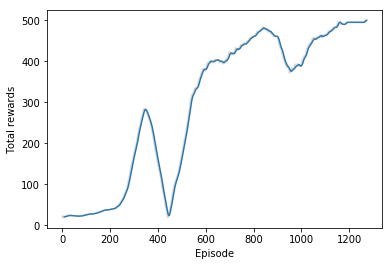

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

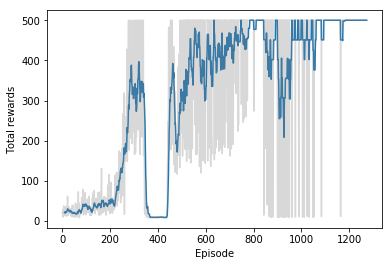

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [18]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [20]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(11):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 200.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 11.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.